Raytracer!

Let me first start by laying down the fundamental data structures and explaining what they do as we go on. I chose the object oriented approach. All of this is needed before we can draw the first simplest image and this was also done to avoid code repetition as much as possible.

<img src="camera.svg" width="800" />

The most physical way would be to shoot rays from all light sources and seeing which ones end up at the camera. However, computationally this would be impossible. It is much better to track the light in the reverse direction by shooting rays from the camera and seeing which ones of them hit light sources. Well, this isn't exactly what raytracing is about either, since the rays that don't hit light sources contribute nothing to the perceived color and hence it suffices to check the rays that do hit light sources. Hence we differentiate diffuse light and specular light.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from abc import ABC, abstractmethod
from PIL import Image


In [2]:
""" This class represents a ray (or mathematically a line that has a location and direction vector)
    which is 1) shot from the camera 2) when object is hit, multiple rays are shot from that location
    to light sources etc."""
class Ray:
    def __init__(self, ray, origin):
        self.ray = ray / np.sqrt(ray.dot(ray))
        self.origin = origin
    def findObstacles(self, objects):
        hits = []
        for s in objects:
            res = s.rayintersect(self)
            if res.hitdist > 0:
                hits.append(res)
        # return the zbuffer, don't sort or find minimun yet, we might need more info later
        return hits
        

In [3]:
# Abstract base class for all objects. Not really needed in python, but it's a good practice nonetheless
# All renderable object must implement this interface since the intersections are calculated differently for different objects
class Object:
    """
    returns hitdist, hitloc and hitnormal as a RTResult object
    """
    @abstractmethod
    def rayintersect(self, raytracer):
        pass
    """"""

In [4]:
"""
The rayintersect method could return a tuple, but this way is much neater
hitdist is distance from the camera to the object that was hit. If there are multiple intersections, this is the smallest one
hitloc is the point in 3d space that was hit, the point of intersection
color is the object color to simplify the code a bit. This could as well be a reference to the object itself or the object's material property etc. 
hitnormal is the normal along the surface of the object at the point of intersection
"""

class RTResult:
    def __init__(self):
        self.hitdist = -1
        self.hitnormal = np.array([0,0,0])
        self.hitloc = np.array([0,0,0])
        self.color = (0,0,0)

In [5]:
class Sphere(Object):
    # Spheres have center point in 3d space and a radius
    def __init__(self, radius, origin, color):
        self.center = origin
        self.r = radius
        self.color = color
    # Here I programmed the sphere's equation in 3d space and solved it
    def rayintersect(self, rt):
        res = RTResult()
        # Translated origin
        v = self.center - rt.origin
        # Solve the equation of the sphere:
        # https://en.wikipedia.org/wiki/Line%E2%80%93sphere_intersection
        # Turns out it's quadratic
        vv = v.dot(v)
        vr = v.dot(rt.ray)
        D = vr*vr - vv + self.r*self.r
        # Check if a solution exists
        if D >= 0:
            # Find a precise value for it and update res
            res.hitdist = vr - np.sqrt(D)
            res.hitloc = rt.origin + res.hitdist * rt.ray
            res.hitnormal = (res.hitloc - v) / self.r
            res.color = self.color
        
        return res
        

In [6]:
# A plane is described by its normal and its distance from the origin.
class Plane(Object):
    def __init__(self, away, normal, color):
        self.n = normal
        self.d = away
        self.color = color
    # Here I have programmed the line-plane intersection equation and solved it in 3d space
    #https://en.wikipedia.org/wiki/Euclidean_planes_in_three-dimensional_space#Point%E2%80%93normal_form_and_general_form_of_the_equation_of_a_plane
    def rayintersect(self, rt):
        res = RTResult()
        # Ray perpendicular = no hit
        proj = self.n.dot(rt.ray)
        if abs(proj) >= 1e-4:
            res.hitdist = -(self.d + self.n.dot(rt.origin)) / proj
            res.hitloc = rt.origin + res.hitdist * rt.ray
            res.hitnormal = self.n
            res.color = self.color
        
        return res

In [7]:
# Camera class takes care of dividing the viewport into vectors of direction for the raytracer
# It also holds the image data inside.
class Camera:
    # possible TODO add parameters origin and lookat
    # Or implement these rotations in the scene class
    # (for example in opengl the camera never moves so this is OK solution)
    def __init__(self,w,h):
        self.im = Image.new("RGB", (w,h), "white")
        self.pixels = self.im.load()
        self.w = w
        self.h = h
        # Rectangle from (-1,-1) to (1,1) in z = 1 plane
        # Generate the viewport vectors
        self.dx = np.array([1,0,0]) / w * 2
        self.dy = np.array([0,1,0]) / h * 2
        self.corner = np.array([-1,-1,1])
    
    # Call the raytrace function for each pixel
    def render(self, scene):
        for j in range(h):
            # Uncomment to see progress
            print("progress: ", j/h, "%")
            for i in range(w):
                ray = self.corner + i * self.dx + j * self.dy
                # We'll have the ray class normalize itself. For now only the direction matters.
                rt = Ray(ray, np.array([0,0,0]))
                color = raytrace(rt, scene)

                if color is None:
                    continue
                # This is the part where dithering would happen

                # This ugly conversion formula is just an artifact of the library I used.
                self.pixels[j,i] = tuple(color.astype(int))
        
    def show(self):
        display(self.im)
        

In [8]:
# The scene class is responsible for all the objects and light sources in the scene.
# It would also be responsible for transforming the world but due to time constraints I have not implemeneted rotations
class Scene: # And camera
    def __init__(self):
        self.objects = []
        # Lightsource could implement the object class, but this simplifies the program a bit.
        self.lightsources = []
        self.cloudSize = 5
    
    def addObj(self, o):
        self.objects.append(o)
    
    def addSphere(self, r, x, y, z, R, G, B):
        self.addObj(Sphere(r, np.array([x,y,z]), np.array([R,G,B])))
    
    # NOTE: At this point I will point out that this may seem very redundant. A single object
    # class would be enough if we use sphere radius = plane away and sphere center = plane normal.
    # We would need additional variable to determine what type of object we have. BUT for future the abstraction
    # and latter specification is useful, not to mention that the methods defined in each class are useful.
    
    # Normal x,y,z
    def addPlane(self, away, x,y,z,R,G,B):
        self.addObj(Plane(away, np.array([x,y,z]), np.array([R,G,B])))
    # Point lights create sharp edges on shadows.
    # -> we don't want that, it generally looks bad
    # To simulate area lighting we add a cloud of point light sources around a center point.
    def addLS(self, x, y, z, r, g, b):
        center = np.array([x, y, z])
        colour = np.array([r, g, b])
        for i in range(self.cloudSize):
            self.lightsources.append(Sphere(1e-3, center + 1e-1 * np.random.rand(3), colour))
    
    # The scene class could handle rotations and translations of all objects, but for simplicity I will not do it in this program.

In [9]:
# Define the scene

scene = Scene()
scene.addSphere(1, 0, 0, 3, 0  , 255, 0  ) 
scene.addSphere(1, 2, 2, 2, 0  , 0  , 255)
scene.addSphere(6, 7, 7, 15, 250, 0, 0  ) 
scene.addSphere(3, 7, -4, 7, 255  , 0  , 255)
scene.addPlane (15, 0, 0,-1, 255, 255, 0  ) # yellow back
scene.addPlane (7,-1, 0, 0, 128, 0, 128) # purple bottom
scene.addPlane (15, 1, 0, 0, 0, 100, 100  ) # dark cyan top
scene.addPlane (7, 0, 1, 0, 0, 0, 128) # Dark blue left 
scene.addPlane (7, 0, 0, 1, 200, 0, 0  ) # red back
scene.addPlane (7, 0,-1, 0, 200, 150, 40) # right
scene.addLS(-3, 6.5, -5, 170, 0,0)
scene.addLS( 3, -6.5, -5, 150, 70, 20)
scene.addLS( 0,0,5, 150,150,150)
scene.addLS( -8,0,5, 0,0,150)

At this point it would be a good point to discuss what is happening with the actual rendering process. The first example is a camera with perspective. I have not programmed any projection or rotation matrices into this code, yet you see circles on the screen that came from the equation for a _sphere_. The first example works by drawing an infinite line from the origin (camera location) through each pixel on the screen and copying the colour of the object that it hits onto the screen. It also adds some very simple shading to add to that perspective projection effect.

In [10]:
# The meat of our program. We will keep improving and redefining this function
# This is the only function we need to modify. This would fit nicely inside the Ray class, but it will be easier to redefine it if it's on the outside
def raytrace(rt, scene):
        zbuf = rt.findObstacles(scene.objects)
        # check if zbuffer is nonempty
        # Empty = no hits hence undefined color on screen.
        if not zbuf:
            return
        
        # Find the closest hit
        best = min(zbuf, key=lambda r: r.hitdist)
        basecolor = best.color
        
        # For the first proof of concept we create a very simple shader
        cos = abs(best.hitnormal.dot(rt.ray))
        color = basecolor * cos
        return color

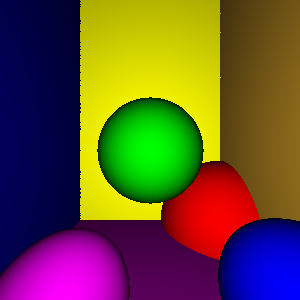

In [11]:
w = 300
h = 300
camera = Camera(w,h)
camera.render(scene)
camera.show()

The rendering equation
$$
L_o(p,\omega_o) = L_e(p,\omega_o) + \int_{S^2} f(p,\omega_o,\omega_i)L_i(p,\omega_i)|cos\theta_i|d\omega_i
$$

where p is position in the scene, L is luminance, subscript o stands for outgoing, i for incident and e is emitted by the object itself, f is a bidirectional reflectance distribution function (BRDF) and theta is the angle between the incident and outgoing rays of light. The $ S^2 $ is integration space. Since $ \omega $ is a direction vector, one can think of the $ S^2 $ as a spherical shell. However we don't want to shoot rays back into the object itself (we're interested in the specular light after all, and this effect would be included in the $ L_e $ term anyway), so the $ S^2 $ is generally a hemisphere.

The BRDF tells us how much light is transmitted between the two given directions of light and is therefore a basically a 2D-probability distribution function. We will discuss the BRDF more in detail later. 

The most important factor contributing to the perceived colour are the external light sources. The specular light from other objects is less signifficant. That is why it is benefitial to treat the light sources separately, since this will speed up the rendering process. Generally there are far less light sources than other types of objects in a given scene. Hence it suffices to sample only a few directions along with the light sources to get good looking image. This gives raise to the use of Monte Carlo methods to solve the rendering equation.

Essentially the diffuse light is doing the bulk of work and that is what we will be implementing next. Strictly speaking this is not Monte Carlo yet. We just do the majority of the work by being smart. The specular light sampling gives a better approximation for the final value of the integral and that is our MC simulation.

In [12]:
def raytrace(rt, scene):
        zbuf = rt.findObstacles(scene.objects)
        # check if zbuffer is nonempty
        if not zbuf:
            return 
        

        best = min(zbuf, key=lambda r: r.hitdist)
        
        basecolor = best.color
        new_origin= best.hitloc
        normal    = best.hitnormal
        
        # Okay we found an object
        # Next find out the incident light from lightsources (diffuse light)

        diffuseLight = np.zeros(3)
        for ls in scene.lightsources:
            direction = ls.center - new_origin
            LSdist = np.sqrt(direction.dot(direction))
            direction = direction / LSdist
            # for numerical stability
            rt = Ray(direction, new_origin + direction*1e-4)
            zbuf = rt.findObstacles(scene.objects)
            # Did we hit anything? Is there anything in the way of our light source?
            # This check causes shadows to appear in the scene. This was computationally expensive
            # in the early days of raycasters and no one invented a better way to figure out shadows.
            if any(r.hitdist < LSdist for r in zbuf):
                continue


            # nope there wasn't, add diffuse light to the mix

            # Not exactly, but in real life applications the exponent is very close to 2.0
            attenuation = 1 + np.power(LSdist / 16.0, 2.0) # TODO test with smaller value
            diffuseEffect = abs(normal.dot(direction)) / scene.cloudSize / attenuation
            diffuseLight += ls.color * diffuseEffect
        
        
        # Then the specular light from other object
        specularLight = np.zeros(3)
        
        # These have to be adjusted accordingly for example for the number of light sources.
        diffuseLight *= .5
        specularLight *= .75
        
        color = (diffuseLight + specularLight) * basecolor / 255

        return color

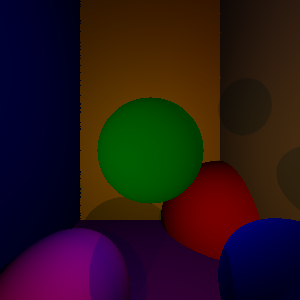

In [13]:
w = 300
h = 300
camera = Camera(w,h)
camera.render(scene)
camera.show()

Next we need a few more things. I'm on a tight schedule but I very badly want to implement a BRDF. There are four kinds of shaders which I want to discuss: diffuse, glossy, mirror and metal. The mirror shader is the easiest to understand. There is no randomness involved. It simply is the resulting vector after flipping the normal direction. The glossy shader is very similar to the mirror as the name suggest. But instead of there being one possible direction, the distribution is actually a bit more random, while the general direction is the mirrored ray direction. The diffuse shader is computationally the easiest. You just sample random vectors on a unit hemisphere, resulting in the rays going isotropically in all directions. The metal shader is the most interesting. What actually happens on a metallic surface is that light likes to go parallel to that surface. Therefore if we do our sampling in spherical coordinates, we only need to sample the azimuthal angle and zero for the polar angle. To implement the specular light properly we need to implement the BRDF and sampling algorithms first.

<img src="brdf.svg" width="600" />

Given a random variable, its probability probability density function (PDF) simply gives us the likelyhood that a sampled random variable is that value or on a given interval. More formally
\begin{equation}
    p = \texttt{PDF}(x)
\end{equation}
gives us the probability p of measuring the random variable at x. An important property of PDF's is that its integral over its domain must be equal to one. It directly follows that PDF must be integrable.

The cumulative distribution function (CDF) is nothing more than the cumulative sum (or integral) of the PDF over its domain. As such, its value must begin from zero and end at 1. The CDF and the PDF have the same domain.

Given a PDF we cannot always get the CDF, as it might not have an integral function even though over its domain it's integrable. However, we can always obtain the PDF from the CDF by taking the derivative of it. Moreover, in certain problems it is much easier to begin by determining the CDF and then finding the PDF using that.
\begin{equation}
    \texttt{PDF}(x) = \frac{d}{dx} \texttt{CDF}(x) \iff \int_{-\inf}^{x} \texttt{PDF}(x') dx' = \texttt{CDF}(x)
\end{equation}

Depending on the application, the CDF might be even more useful tool than the PDF. For example, by finding its inverse function, $ \texttt{CDF}^{-1} $ can be used for very efficient probability sampling. This is called inverse sampling. To do this we come up with a distribution and its CDF. Then we find the inverse of the CDF and we plug in values from the uniform distribution to get values that have our arbitrary distribution.

In [14]:
# y is the surface normal and will 
def coordinateSystem(y, ray):
    # Assume n is normalized (or normalize again?)
    y /= np.sqrt(y.dot(y))
    proj = y.dot(ray)
    # Orthogonalize the ray to make one of the basis vectors
    # be the projection of the ray along the surface
    x = ray - y * proj
    x /= np.sqrt(x.dot(x))
    
    # get the third basis vector with cross product
    z = np.cross(x,y)
    
    return x,y,z

# Default six samples from the uniform distribution
def sample(N=6, cdfinv=lambda s: s):
    samples = np.random.rand(N)
    return cdfinv(samples)
    
def construct(x,y,z, sivu, koro):
    return np.sin(koro) * np.cos(sivu) * x + np.sin(koro) * np.sin(sivu) * y + np.cos(koro) * z 

In [15]:
# Sanity check
x = np.array([1.0, 0.0, 0.0])
y = np.array([0.0, 1.0, 0.0])
z = np.array([0.0, 0.0, 1.0])

print(coordinateSystem(y,x))
print(coordinateSystem(z,x))
print(coordinateSystem(y,z))

(array([1., 0., 0.]), array([0., 1., 0.]), array([0., 0., 1.]))
(array([1., 0., 0.]), array([0., 0., 1.]), array([ 0., -1.,  0.]))
(array([0., 0., 1.]), array([0., 1., 0.]), array([-1.,  0.,  0.]))


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0.61547971 0.61547971 0.61547971 0.61547971 0.61547971 0.61547971
 0.61547971 0.61547971 0.61547971 0.61547971 0.61547971 0.61547971
 0.61547971 0.61547971 0.61547971 0.61547971 0.61547971 0.61547971
 0.61547971 0.61547971 0.61547971 0.61547971 0.61547971 0.61547971
 0.61547971 0.61547971 0.61547971 0.61547971 0.61547971 0.61547971
 0.61547971 0.61547971 0.61547971 0.61547971 0.61547971 0.61547971
 0.61547971 0.61547971 0.61547971 0.61547971 0.61547971 0.61547971
 0.61547971 0.61547971 0.61547971 0.61547971 0.61547971 0.61547971
 0.61547971 0.61547971]


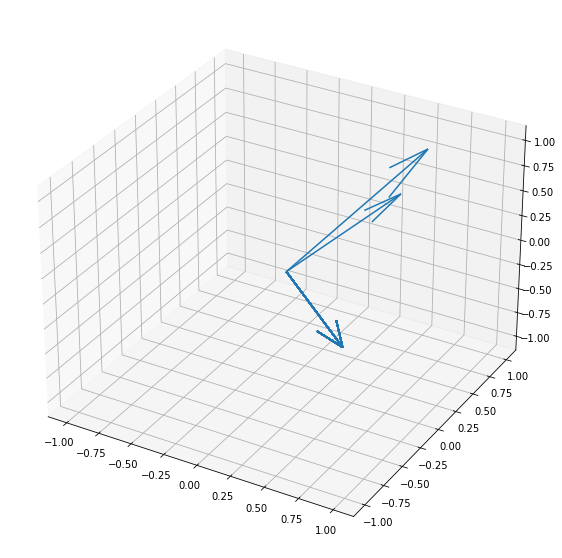

In [19]:
 # proof of concept only
    # because I ran out of time
n = np.array([1.0,2.0,1.0])
d = np.array([0.0,2.0,0.0])


from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['figure.figsize'] = [20, 10]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

def drawVector(u):
    ax.quiver(0, 0, 0, u[0], u[1], u[2])

# Diffuse
sivut = sample(50, cdfinv=lambda s: np.pi*(1-2*s))
korot = sample(50, cdfinv=lambda s: np.pi*(s))

# Glossy: this is why it is benefitial to choose the x axis to be along the
# propagating direction. The vector has small variance around the direction of x.
# So for the angle, we must sample polar angles close to zero
# Same for the azimuthal angle, but we need the angle of incidence or cos thereof

# We want a sort of fake normal distribution
# y=cos(A(x-mu))
# domain cos(A(x-mu)) = 0 <=> x = mu + (+- pi/2 + n2pi) / A => first roots mu +- pi/2A
# Normalize, we get normalisation constant C = 2 / A
# So then the CFD = 2/A^2sin(A(x-mu))
# CFDinv = arcsin(A^2y/2)/A + mu
# The parameter A is probably related to standard deviation

inc = abs(np.arccos(d.dot(n) / np.sqrt(n.dot(n)*d.dot(d))))

def fakegauss(y, A=4, mu=0):
    return np.arcsin(.5*A*A*y)/A + mu
#sivut = sample(50, cdfinv=lambda s: fakegauss(s))
#korot = sample(50, cdfinv=lambda s: fakegauss(s, mu=inc))

# To be crystal clear, we are sampling angles in spherical coordinates. The uniform distribution could give us values between -1 and 1 for example, which would be sines and cosines
# Mirror. easy. no random numbers needed.
sivut = sample(50, cdfinv=lambda s: np.zeros_like(s))
korot = sample(50, cdfinv=lambda s: np.ones_like(s)*inc)

# Metal shader. inclination = 0, polar angle is uniformly distributed
#sivut = sample(50, cdfinv=lambda s: s)
#korot = sample(50, cdfinv=lambda s: np.zeros_like(s))

print(sivut)
print(korot)

x,y,z = coordinateSystem(n, d)

#drawVector(x)
#drawVector(y)
#drawVector(z)


drawVector(n)
drawVector(d)

for sivu, koro in zip(sivut, korot):
    vec = construct(x,y,z,sivu, koro)
    drawVector(vec)
    
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])
ax.set_zlim([-1.1, 1.1])
plt.show()


To implement specular lighting, that is literally reflections, we want to implement recursion. We want to run the raytracing algorithm all over again to get the incident light to the point we are at now. To do this we refactor our code again.

In [17]:
def raytrace(rt, scene, recursionDepth = 4):
        zbuf = rt.findObstacles(scene.objects)
        # check if zbuffer is nonempty
        if not zbuf:
            return

        best = min(zbuf, key=lambda r: r.hitdist)
        
        basecolor = best.color
        new_origin= best.hitloc
        normal    = best.hitnormal
        
        # Okay we found an object
        # Next find out the incident light from lightsources (diffuse light)
        diffuseLight = np.zeros(3)
        for ls in scene.lightsources:
            direction = ls.center - new_origin
            LSdist = np.sqrt(direction.dot(direction))
            direction = direction / LSdist
            # for numerical stability
            rt = Ray(direction, new_origin + direction*1e-4)
            zbuf = rt.findObstacles(scene.objects)
            # Did we hit anything? Is there anything in the way of our light source?
            if any(r.hitdist < LSdist for r in zbuf):
                continue
            
            # nope there wasn't, add diffuse light to the mix
            # Not exactly, but in real life applications the exponent is very close to 2.0
            attenuation = 1 + np.power(LSdist / 34.0, 2.0)
            diffuseEffect = abs(normal.dot(direction)) / scene.cloudSize / attenuation
            diffuseLight += ls.color * diffuseEffect
                    
        # Then the specular light from other object
        specularLight = np.zeros(3)
        
        if recursionDepth > 0:
            # PLACEHOLDER: DO THE BRDF HERE
            # Really not much here, if you have ever played pong this function does the same about an arbitrary surface normal.
            
            
            # Due to time constraints I was unable to get the probability sampling working reliably
            # so instead I present you an alternative ways to do the mirror shader.
            # There is no point in sampling here, since with the mirror shader it is always the same direction
            # but for example the diffusion shader, you could do 50 samples in isotropic directions and adding the colors
            
            samples = 1 # 50
            for k in range(samples):
                proj = normal.dot(rt.ray)
                new_dir = rt.ray - 2 * proj * normal # new_dir = sample new dir according to BRDF

                # Shoot a ray from the object surface to find out how that is illmuninated
                s = raytrace(Ray(new_dir, new_origin + new_dir * 1e-4), scene, recursionDepth-1)
                # Check that there is in fact light coming in
                if s is not None:
                    specularLight = specularLight + s # / samples, probs want to do this
        
        diffuseLight *= .85
        specularLight *= .60
        
        color = (diffuseLight + specularLight) * basecolor / 255
        return color

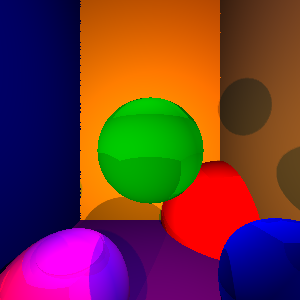

In [18]:
w = 300
h = 300
camera = Camera(w,h)
camera.render(scene)
camera.show()

In [ ]:
w = 1000
h = 1000
camera = Camera(w,h)
camera.render(scene)
camera.show()